In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig = sig[sig.SR == 2]

bg = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg['is_signal'] = False
# bg = bg[bg.SR == 2]

In [4]:
train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                              'Zcand_mass', 'chisq']])

train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [6]:
# Normalize training features
X = pd.concat([sig[train_feats_raw], bg[train_feats_raw]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

In [51]:
# Load per-background models
models_dir = 'models/background_id_models/'

background_classifiers = {'ZZ': 1, 'Zjets': 2, 'WZ': 1, 'ttZ': 0, 'other': 1}

for bc_name in background_classifiers:
    bc_index = background_classifiers[bc_name]
    
    classifier = keras.models.load_model((models_dir + 'classifier_' + bc_name 
                                          + '_train_feat_test_' + str(bc_index)))
    sig['classifier_' + bc_name + '_score'] = classifier.predict(sig[train_feat_sets[bc_index]], 
                                                                    batch_size=10000)
    bg['classifier_' + bc_name + '_score'] = classifier.predict(bg[train_feat_sets[bc_index]], 
                                                                   batch_size=10000)

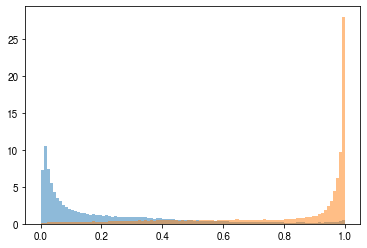

In [52]:
_, b, _ = plt.hist(bg.classifier_ZZ_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_ZZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

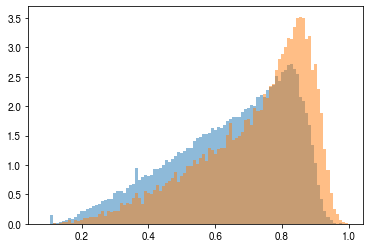

In [53]:
_, b, _ = plt.hist(bg.classifier_Zjets_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_Zjets_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

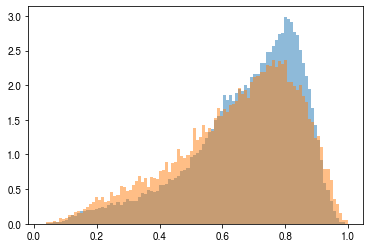

In [54]:
_, b, _ = plt.hist(bg.classifier_WZ_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_WZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

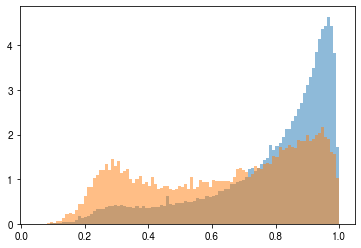

In [55]:
_, b, _ = plt.hist(bg.classifier_ttZ_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_ttZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

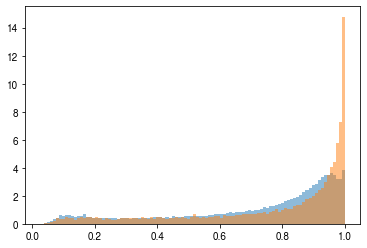

In [56]:
_, b, _ = plt.hist(bg.classifier_other_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_other_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

In [57]:
# Cut to 4l-DF signal region
bg = bg[bg.SR == 1]
sig = sig[sig.SR == 1]

# Train model

First we want to figure out the signal/background ratio

In [60]:
def region_sig(s, b):
    if s == 0:
        return 0
    return np.sqrt(2 * ((s + b) * np.log(1 + s / b) - s))

n_bg = sum(bg.wgt)
n_sig = sum(sig.wgt)

print('There are', n_bg, 'background events')
print('There are', n_sig, 'signal events')
print('')
print('S/B =', n_sig/n_bg)
print('Starting significance is', region_sig(n_sig, n_bg), 'sigma')
print('Corresponds to', np.sqrt(2.0) * region_sig(n_sig, n_bg), 'sigma')

There are 38.30702696298086 background events
There are 6.760975084128499 signal events

S/B = 0.17649438288860603
Starting significance is 1.0623934062436122 sigma
Corresponds to 1.5024511636854656 sigma


In [61]:
bg['abs_wgt'] = np.abs(bg.wgt)
sig['abs_wgt'] = np.abs(sig.wgt)

/tmp/kbenkend/ipykernel_56255/2235700710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg['abs_wgt'] = np.abs(bg.wgt)
/tmp/kbenkend/ipykernel_56255/2235700710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['abs_wgt'] = np.abs(sig.wgt)


In [62]:
sig.columns

Index(['index', 'pt_4l', 'SR', 'Wlep1_pt', 'Zlep1_phi', 'Wlep1_pid',
       'leptonic_HT', 'Zlep2_pt', 'METSig', 'Wlep2_phi', 'chisq', 'Zlep2_phi',
       'MET', 'other_mass', 'total_HT', 'Wlep2_pid', 'Zlep1_eta', 'Wlep1_dphi',
       'Zlep1_pt', 'Zlep2_dphi', 'HT', 'wgt', 'pt_2', 'pt_4', 'pt_3',
       'Wlep1_eta', 'Wlep2_dphi', 'Zlep2_eta', 'Zcand_mass', 'pt_1', 'Njet',
       'Zlep1_dphi', 'Zlep1_pid', 'Wlep2_pt', 'Nlep', 'Wlep2_eta', 'mass_4l',
       'Zlep2_pid', 'Wlep1_phi', 'is_signal', 'classifier_ZZ_score',
       'classifier_Zjets_score', 'classifier_WZ_score', 'classifier_ttZ_score',
       'classifier_other_score', 'abs_wgt'],
      dtype='object')

In [66]:
bg_classifier_score_feats = ['classifier_' + bc + '_score' for bc in background_classifiers]
combined_train_feats_raw = train_feats_raw + bg_classifier_score_feats

combined_train_feat_sets = [combined_train_feats_raw, 
                            [f for f in combined_train_feats_raw if f not in bg_classifier_score_feats],
                            [f for f in combined_train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 
                                                                              'Zlep1_phi', 'Zlep2_phi']],
                            [f for f in combined_train_feats_raw if f not in ['MET', 'METSig']],
                            [f for f in combined_train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                            [f for f in combined_train_feats_raw if f not in ['Njet', 'Nlep']]
                           ]

In [73]:
EPOCHS = 10000
patience = 500
batch_size = 256
num_nodes = 64
dropout = 0.1
learn_rate = 1e-5

for i, train_feats in enumerate(combined_train_feat_sets):
    model_dir = 'models/SR_4l_DF_models/'
    model_name = 'classifier_train_feat_test_' + str(i)
    
    print('Running with training features:', train_feats)
    # Save training setup
    with open(model_dir + model_name + '_setup.txt', 'w') as file:
        file.write('Epochs: ' + str(EPOCHS) + '\n')
        file.write('Patience: ' + str(patience) + '\n')
        file.write('Learning rate: ' + str(learn_rate) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n\n')
        file.write('Training features:\n' + '\n'.join(train_feats))
    
    # Generate train and test samples
    sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5, random_state=314)
    bg_train, bg_test = train_test_split(bg[train_feats + ['wgt']], train_size=0.5, random_state=314)

    n_sig = sum(sig_train.wgt)
    n_bg = sum(bg_train.wgt)

    x_train_sig = sig_train[train_feats]
    x_train_bg = bg_train[train_feats]

    x_train = pd.concat([x_train_sig, x_train_bg])
    y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))])
    w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                        (n_sig + n_bg) / n_bg * bg_train['wgt']]))

    n_sig_test = sum(sig_test.wgt)
    n_bg_test = sum(bg_test.wgt)

    x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
    y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
    w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                       (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))
    
    # Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                             validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                             verbose=1, callbacks=[callback], shuffle=True)
    
    # Save model and history
    classifier.save(model_dir + model_name)
    with open(model_dir + model_name + '_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT', 'classifier_ZZ_score', 'classifier_Zjets_score', 'classifier_WZ_score', 'classifier_ttZ_score', 'classifier_other_score']
Epoch 1/10000
62/62 [==============================] - 1s 8ms/step - loss: 0.0020 - accuracy: 0.4767 - val_loss: 0.0020 - val_accuracy: 0.4078
Epoch 2/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.4726 - val_loss: 0.0020 - val_accuracy: 0.4085
Epoch 3/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.4805 - val_loss: 0.0020 - val_accuracy: 0.4042
Epoch 4/10000
62/6

Epoch 111/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6350 - val_loss: 0.0016 - val_accuracy: 0.6435
Epoch 112/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6267 - val_loss: 0.0016 - val_accuracy: 0.6450
Epoch 113/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6275 - val_loss: 0.0016 - val_accuracy: 0.6435
Epoch 114/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6263 - val_loss: 0.0016 - val_accuracy: 0.6431
Epoch 115/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6273 - val_loss: 0.0016 - val_accuracy: 0.6436
Epoch 116/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6314 - val_loss: 0.0016 - val_accuracy: 0.6429
Epoch 117/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6381 - val_loss: 0.0016 - val_ac

62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6454 - val_loss: 0.0015 - val_accuracy: 0.6564
Epoch 224/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6560 - val_loss: 0.0015 - val_accuracy: 0.6566
Epoch 225/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6501 - val_loss: 0.0015 - val_accuracy: 0.6557
Epoch 226/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6496 - val_loss: 0.0015 - val_accuracy: 0.6563
Epoch 227/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6459 - val_loss: 0.0015 - val_accuracy: 0.6565
Epoch 228/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6514 - val_loss: 0.0015 - val_accuracy: 0.6581
Epoch 229/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6508 - val_loss: 0.0015 - val_accuracy: 0.6575
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6572 - val_loss: 0.0015 - val_accuracy: 0.6595
Epoch 336/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6536 - val_loss: 0.0015 - val_accuracy: 0.6603
Epoch 337/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6613 - val_loss: 0.0015 - val_accuracy: 0.6574
Epoch 338/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6558 - val_loss: 0.0015 - val_accuracy: 0.6570
Epoch 339/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6503 - val_loss: 0.0015 - val_accuracy: 0.6582
Epoch 340/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6496 - val_loss: 0.0015 - val_accuracy: 0.6598
Epoch 341/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6561 - val_loss: 0.0015 - val_accuracy: 0.6571
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6574 - val_loss: 0.0015 - val_accuracy: 0.6619
Epoch 448/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6575 - val_loss: 0.0015 - val_accuracy: 0.6616
Epoch 449/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6524 - val_loss: 0.0015 - val_accuracy: 0.6626
Epoch 450/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6620 - val_loss: 0.0015 - val_accuracy: 0.6623
Epoch 451/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6609 - val_loss: 0.0015 - val_accuracy: 0.6624
Epoch 452/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6551 - val_loss: 0.0015 - val_accuracy: 0.6628
Epoch 453/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6506 - val_loss: 0.0015 - val_accuracy: 0.6607
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6510 - val_loss: 0.0015 - val_accuracy: 0.6642
Epoch 560/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6583 - val_loss: 0.0014 - val_accuracy: 0.6645
Epoch 561/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6578 - val_loss: 0.0015 - val_accuracy: 0.6628
Epoch 562/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6586 - val_loss: 0.0014 - val_accuracy: 0.6638
Epoch 563/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6568 - val_loss: 0.0014 - val_accuracy: 0.6639
Epoch 564/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6637 - val_loss: 0.0015 - val_accuracy: 0.6628
Epoch 565/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6609 - val_loss: 0.0015 - val_accuracy: 0.6629
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6693 - val_loss: 0.0014 - val_accuracy: 0.6652
Epoch 672/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6663 - val_loss: 0.0014 - val_accuracy: 0.6655
Epoch 673/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6591 - val_loss: 0.0014 - val_accuracy: 0.6651
Epoch 674/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6600 - val_loss: 0.0014 - val_accuracy: 0.6658
Epoch 675/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6623 - val_loss: 0.0014 - val_accuracy: 0.6659
Epoch 676/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6577 - val_loss: 0.0014 - val_accuracy: 0.6649
Epoch 677/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6669 - val_loss: 0.0014 - val_accuracy: 0.6662
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6648 - val_loss: 0.0014 - val_accuracy: 0.6637
Epoch 784/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6642 - val_loss: 0.0014 - val_accuracy: 0.6651
Epoch 785/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6649 - val_loss: 0.0014 - val_accuracy: 0.6645
Epoch 786/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6660 - val_loss: 0.0014 - val_accuracy: 0.6661
Epoch 787/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6642 - val_loss: 0.0014 - val_accuracy: 0.6661
Epoch 788/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6620 - val_loss: 0.0014 - val_accuracy: 0.6665
Epoch 789/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6592 - val_loss: 0.0014 - val_accuracy: 0.6654
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6613 - val_loss: 0.0014 - val_accuracy: 0.6666
Epoch 896/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6696 - val_loss: 0.0014 - val_accuracy: 0.6652
Epoch 897/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6610 - val_loss: 0.0014 - val_accuracy: 0.6650
Epoch 898/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6697 - val_loss: 0.0014 - val_accuracy: 0.6662
Epoch 899/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6635 - val_loss: 0.0014 - val_accuracy: 0.6658
Epoch 900/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6618 - val_loss: 0.0014 - val_accuracy: 0.6658
Epoch 901/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6616 - val_loss: 0.0014 - val_accuracy: 0.6660
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6660 - val_loss: 0.0014 - val_accuracy: 0.6683
Epoch 1008/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6666 - val_loss: 0.0014 - val_accuracy: 0.6673
Epoch 1009/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6660 - val_loss: 0.0014 - val_accuracy: 0.6673
Epoch 1010/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6688 - val_loss: 0.0014 - val_accuracy: 0.6670
Epoch 1011/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6683 - val_loss: 0.0014 - val_accuracy: 0.6680
Epoch 1012/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6643 - val_loss: 0.0014 - val_accuracy: 0.6678
Epoch 1013/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6661 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6671 - val_loss: 0.0014 - val_accuracy: 0.6710
Epoch 1120/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6753 - val_loss: 0.0014 - val_accuracy: 0.6712
Epoch 1121/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6707 - val_loss: 0.0014 - val_accuracy: 0.6708
Epoch 1122/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6742 - val_loss: 0.0014 - val_accuracy: 0.6732
Epoch 1123/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6697 - val_loss: 0.0014 - val_accuracy: 0.6726
Epoch 1124/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6737 - val_loss: 0.0014 - val_accuracy: 0.6712
Epoch 1125/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6722 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6750 - val_loss: 0.0014 - val_accuracy: 0.6749
Epoch 1232/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6735 - val_loss: 0.0014 - val_accuracy: 0.6749
Epoch 1233/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6776 - val_loss: 0.0014 - val_accuracy: 0.6753
Epoch 1234/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6742 - val_loss: 0.0014 - val_accuracy: 0.6752
Epoch 1235/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6740 - val_loss: 0.0014 - val_accuracy: 0.6743
Epoch 1236/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6676 - val_loss: 0.0014 - val_accuracy: 0.6742
Epoch 1237/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6684 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.6699 - val_loss: 0.0014 - val_accuracy: 0.6744
Epoch 1344/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6760 - val_loss: 0.0014 - val_accuracy: 0.6762
Epoch 1345/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6732 - val_loss: 0.0014 - val_accuracy: 0.6756
Epoch 1346/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6712 - val_loss: 0.0014 - val_accuracy: 0.6745
Epoch 1347/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6662 - val_loss: 0.0014 - val_accuracy: 0.6729
Epoch 1348/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6767 - val_loss: 0.0014 - val_accuracy: 0.6729
Epoch 1349/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6738 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6778 - val_loss: 0.0014 - val_accuracy: 0.6750
Epoch 1456/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6730 - val_loss: 0.0014 - val_accuracy: 0.6768
Epoch 1457/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6629 - val_loss: 0.0014 - val_accuracy: 0.6757
Epoch 1458/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6784 - val_loss: 0.0014 - val_accuracy: 0.6761
Epoch 1459/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6773 - val_loss: 0.0014 - val_accuracy: 0.6759
Epoch 1460/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6731 - val_loss: 0.0014 - val_accuracy: 0.6763
Epoch 1461/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6760 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6757 - val_loss: 0.0014 - val_accuracy: 0.6768
Epoch 1568/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6721 - val_loss: 0.0014 - val_accuracy: 0.6768
Epoch 1569/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6809 - val_loss: 0.0014 - val_accuracy: 0.6777
Epoch 1570/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6746 - val_loss: 0.0014 - val_accuracy: 0.6761
Epoch 1571/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6808 - val_loss: 0.0014 - val_accuracy: 0.6778
Epoch 1572/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6741 - val_loss: 0.0014 - val_accuracy: 0.6774
Epoch 1573/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 0.6858 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6709 - val_loss: 0.0014 - val_accuracy: 0.6766
Epoch 1680/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6701 - val_loss: 0.0014 - val_accuracy: 0.6768
Epoch 1681/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6783 - val_loss: 0.0014 - val_accuracy: 0.6768
Epoch 1682/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6728 - val_loss: 0.0014 - val_accuracy: 0.6772
Epoch 1683/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6733 - val_loss: 0.0014 - val_accuracy: 0.6777
Epoch 1684/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6838 - val_loss: 0.0014 - val_accuracy: 0.6770
Epoch 1685/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6749 - val_loss: 0.0014 - val_accuracy: 0.

Epoch 9/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.3549 - val_loss: 0.0020 - val_accuracy: 0.3392
Epoch 10/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 0.3568 - val_loss: 0.0020 - val_accuracy: 0.3426
Epoch 11/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.3599 - val_loss: 0.0020 - val_accuracy: 0.3452
Epoch 12/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.3687 - val_loss: 0.0020 - val_accuracy: 0.3484
Epoch 13/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.3673 - val_loss: 0.0020 - val_accuracy: 0.3533
Epoch 14/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.3772 - val_loss: 0.0020 - val_accuracy: 0.3583
Epoch 15/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.3772 - val_loss: 0.0020 - val_accuracy: 

Epoch 66/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.4954 - val_loss: 0.0020 - val_accuracy: 0.5505
Epoch 67/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5123 - val_loss: 0.0020 - val_accuracy: 0.5525
Epoch 68/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5007 - val_loss: 0.0020 - val_accuracy: 0.5526
Epoch 69/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5000 - val_loss: 0.0020 - val_accuracy: 0.5505
Epoch 70/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5022 - val_loss: 0.0020 - val_accuracy: 0.5520
Epoch 71/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 0.5106 - val_loss: 0.0020 - val_accuracy: 0.5515
Epoch 72/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.4983 - val_loss: 0.0020 - val_accuracy:

Epoch 123/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5269 - val_loss: 0.0019 - val_accuracy: 0.5633
Epoch 124/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5319 - val_loss: 0.0019 - val_accuracy: 0.5639
Epoch 125/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5343 - val_loss: 0.0019 - val_accuracy: 0.5671
Epoch 126/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5281 - val_loss: 0.0019 - val_accuracy: 0.5636
Epoch 127/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5286 - val_loss: 0.0019 - val_accuracy: 0.5655
Epoch 128/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5288 - val_loss: 0.0019 - val_accuracy: 0.5658
Epoch 129/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5294 - val_loss: 0.0019 - val_ac

62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5863 - val_loss: 0.0018 - val_accuracy: 0.6242
Epoch 236/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5832 - val_loss: 0.0018 - val_accuracy: 0.6252
Epoch 237/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5943 - val_loss: 0.0018 - val_accuracy: 0.6285
Epoch 238/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5970 - val_loss: 0.0018 - val_accuracy: 0.6309
Epoch 239/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.5954 - val_loss: 0.0018 - val_accuracy: 0.6293
Epoch 240/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5946 - val_loss: 0.0018 - val_accuracy: 0.6298
Epoch 241/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5974 - val_loss: 0.0018 - val_accuracy: 0.6304
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6410 - val_loss: 0.0017 - val_accuracy: 0.6703
Epoch 348/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6303 - val_loss: 0.0017 - val_accuracy: 0.6699
Epoch 349/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6275 - val_loss: 0.0017 - val_accuracy: 0.6703
Epoch 350/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6400 - val_loss: 0.0017 - val_accuracy: 0.6709
Epoch 351/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.6364 - val_loss: 0.0017 - val_accuracy: 0.6714
Epoch 352/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6387 - val_loss: 0.0017 - val_accuracy: 0.6714
Epoch 353/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6368 - val_loss: 0.0017 - val_accuracy: 0.6717
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6494 - val_loss: 0.0016 - val_accuracy: 0.6772
Epoch 460/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6500 - val_loss: 0.0016 - val_accuracy: 0.6772
Epoch 461/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6484 - val_loss: 0.0016 - val_accuracy: 0.6773
Epoch 462/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6476 - val_loss: 0.0016 - val_accuracy: 0.6779
Epoch 463/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6482 - val_loss: 0.0016 - val_accuracy: 0.6777
Epoch 464/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6524 - val_loss: 0.0016 - val_accuracy: 0.6779
Epoch 465/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6569 - val_loss: 0.0016 - val_accuracy: 0.6770
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6594 - val_loss: 0.0016 - val_accuracy: 0.6784
Epoch 572/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6548 - val_loss: 0.0016 - val_accuracy: 0.6790
Epoch 573/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6618 - val_loss: 0.0016 - val_accuracy: 0.6790
Epoch 574/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6631 - val_loss: 0.0016 - val_accuracy: 0.6792
Epoch 575/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6625 - val_loss: 0.0016 - val_accuracy: 0.6787
Epoch 576/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6604 - val_loss: 0.0016 - val_accuracy: 0.6787
Epoch 577/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6549 - val_loss: 0.0016 - val_accuracy: 0.6783
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6616 - val_loss: 0.0016 - val_accuracy: 0.6793
Epoch 684/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6689 - val_loss: 0.0016 - val_accuracy: 0.6800
Epoch 685/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6597 - val_loss: 0.0016 - val_accuracy: 0.6796
Epoch 686/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6539 - val_loss: 0.0016 - val_accuracy: 0.6795
Epoch 687/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6572 - val_loss: 0.0016 - val_accuracy: 0.6798
Epoch 688/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6636 - val_loss: 0.0016 - val_accuracy: 0.6802
Epoch 689/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6685 - val_loss: 0.0016 - val_accuracy: 0.6793
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6713 - val_loss: 0.0016 - val_accuracy: 0.6791
Epoch 796/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6688 - val_loss: 0.0016 - val_accuracy: 0.6786
Epoch 797/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6657 - val_loss: 0.0016 - val_accuracy: 0.6803
Epoch 798/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6636 - val_loss: 0.0016 - val_accuracy: 0.6786
Epoch 799/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6625 - val_loss: 0.0016 - val_accuracy: 0.6789
Epoch 800/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6699 - val_loss: 0.0016 - val_accuracy: 0.6786
Epoch 801/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6606 - val_loss: 0.0016 - val_accuracy: 0.6787
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6681 - val_loss: 0.0015 - val_accuracy: 0.6791
Epoch 908/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6666 - val_loss: 0.0015 - val_accuracy: 0.6789
Epoch 909/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6667 - val_loss: 0.0015 - val_accuracy: 0.6792
Epoch 910/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6600 - val_loss: 0.0015 - val_accuracy: 0.6789
Epoch 911/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6586 - val_loss: 0.0015 - val_accuracy: 0.6789
Epoch 912/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6703 - val_loss: 0.0015 - val_accuracy: 0.6791
Epoch 913/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6654 - val_loss: 0.0015 - val_accuracy: 0.6793
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6694 - val_loss: 0.0015 - val_accuracy: 0.6761
Epoch 1020/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6679 - val_loss: 0.0015 - val_accuracy: 0.6760
Epoch 1021/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6715 - val_loss: 0.0015 - val_accuracy: 0.6768
Epoch 1022/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6670 - val_loss: 0.0015 - val_accuracy: 0.6762
Epoch 1023/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6699 - val_loss: 0.0015 - val_accuracy: 0.6766
Epoch 1024/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6621 - val_loss: 0.0015 - val_accuracy: 0.6760
Epoch 1025/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6628 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6658 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 1132/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6622 - val_loss: 0.0015 - val_accuracy: 0.6751
Epoch 1133/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6565 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 1134/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6664 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 1135/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6664 - val_loss: 0.0015 - val_accuracy: 0.6758
Epoch 1136/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6711 - val_loss: 0.0015 - val_accuracy: 0.6756
Epoch 1137/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6662 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6649 - val_loss: 0.0015 - val_accuracy: 0.6749
Epoch 1244/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6638 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 1245/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6634 - val_loss: 0.0015 - val_accuracy: 0.6746
Epoch 1246/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6650 - val_loss: 0.0015 - val_accuracy: 0.6746
Epoch 1247/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6687 - val_loss: 0.0015 - val_accuracy: 0.6761
Epoch 1248/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6706 - val_loss: 0.0015 - val_accuracy: 0.6759
Epoch 1249/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6646 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6690 - val_loss: 0.0015 - val_accuracy: 0.6742
Epoch 1356/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6703 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 1357/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6738 - val_loss: 0.0015 - val_accuracy: 0.6756
Epoch 1358/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6679 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 1359/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6726 - val_loss: 0.0015 - val_accuracy: 0.6750
Epoch 1360/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6663 - val_loss: 0.0015 - val_accuracy: 0.6758
Epoch 1361/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6663 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6666 - val_loss: 0.0015 - val_accuracy: 0.6745
Epoch 1468/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6626 - val_loss: 0.0015 - val_accuracy: 0.6751
Epoch 1469/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6692 - val_loss: 0.0015 - val_accuracy: 0.6743
Epoch 1470/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6742 - val_loss: 0.0015 - val_accuracy: 0.6752
Epoch 1471/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6719 - val_loss: 0.0015 - val_accuracy: 0.6751
Epoch 1472/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6651 - val_loss: 0.0015 - val_accuracy: 0.6746
Epoch 1473/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6737 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6751 - val_loss: 0.0015 - val_accuracy: 0.6741
Epoch 1580/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6644 - val_loss: 0.0015 - val_accuracy: 0.6751
Epoch 1581/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6638 - val_loss: 0.0015 - val_accuracy: 0.6731
Epoch 1582/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6646 - val_loss: 0.0015 - val_accuracy: 0.6734
Epoch 1583/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6693 - val_loss: 0.0015 - val_accuracy: 0.6736
Epoch 1584/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6585 - val_loss: 0.0015 - val_accuracy: 0.6751
Epoch 1585/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6697 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6740 - val_loss: 0.0015 - val_accuracy: 0.6727
Epoch 1692/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6785 - val_loss: 0.0015 - val_accuracy: 0.6746
Epoch 1693/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6686 - val_loss: 0.0015 - val_accuracy: 0.6740
Epoch 1694/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6644 - val_loss: 0.0015 - val_accuracy: 0.6736
Epoch 1695/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6651 - val_loss: 0.0015 - val_accuracy: 0.6725
Epoch 1696/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6695 - val_loss: 0.0015 - val_accuracy: 0.6743
Epoch 1697/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6681 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6765 - val_loss: 0.0015 - val_accuracy: 0.6749
Epoch 1804/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6626 - val_loss: 0.0015 - val_accuracy: 0.6736
Epoch 1805/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6697 - val_loss: 0.0015 - val_accuracy: 0.6746
Epoch 1806/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6700 - val_loss: 0.0015 - val_accuracy: 0.6738
Epoch 1807/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6700 - val_loss: 0.0015 - val_accuracy: 0.6741
Epoch 1808/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6730 - val_loss: 0.0015 - val_accuracy: 0.6742
Epoch 1809/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6713 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6750 - val_loss: 0.0015 - val_accuracy: 0.6765
Epoch 1916/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6759 - val_loss: 0.0015 - val_accuracy: 0.6753
Epoch 1917/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6753 - val_loss: 0.0015 - val_accuracy: 0.6752
Epoch 1918/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6677 - val_loss: 0.0015 - val_accuracy: 0.6747
Epoch 1919/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6677 - val_loss: 0.0015 - val_accuracy: 0.6756
Epoch 1920/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6677 - val_loss: 0.0015 - val_accuracy: 0.6755
Epoch 1921/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6746 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6648 - val_loss: 0.0015 - val_accuracy: 0.6736
Epoch 2028/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6655 - val_loss: 0.0015 - val_accuracy: 0.6743
Epoch 2029/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6725 - val_loss: 0.0015 - val_accuracy: 0.6747
Epoch 2030/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6667 - val_loss: 0.0015 - val_accuracy: 0.6748
Epoch 2031/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6698 - val_loss: 0.0015 - val_accuracy: 0.6756
Epoch 2032/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6645 - val_loss: 0.0015 - val_accuracy: 0.6749
Epoch 2033/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6719 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6727 - val_loss: 0.0015 - val_accuracy: 0.6744
Epoch 2140/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6743 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 2141/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6726 - val_loss: 0.0015 - val_accuracy: 0.6763
Epoch 2142/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6734 - val_loss: 0.0015 - val_accuracy: 0.6757
Epoch 2143/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6751 - val_loss: 0.0015 - val_accuracy: 0.6756
Epoch 2144/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6741 - val_loss: 0.0015 - val_accuracy: 0.6749
Epoch 2145/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6742 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6769 - val_loss: 0.0015 - val_accuracy: 0.6772
Epoch 2252/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6706 - val_loss: 0.0015 - val_accuracy: 0.6782
Epoch 2253/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6676 - val_loss: 0.0015 - val_accuracy: 0.6778
Epoch 2254/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6703 - val_loss: 0.0015 - val_accuracy: 0.6768
Epoch 2255/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6722 - val_loss: 0.0015 - val_accuracy: 0.6772
Epoch 2256/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6780 - val_loss: 0.0015 - val_accuracy: 0.6775
Epoch 2257/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6689 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6793 - val_loss: 0.0015 - val_accuracy: 0.6761
Epoch 2364/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6697 - val_loss: 0.0015 - val_accuracy: 0.6760
Epoch 2365/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6805 - val_loss: 0.0015 - val_accuracy: 0.6795
Epoch 2366/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6768 - val_loss: 0.0015 - val_accuracy: 0.6779
Epoch 2367/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6793 - val_loss: 0.0015 - val_accuracy: 0.6773
Epoch 2368/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6731 - val_loss: 0.0015 - val_accuracy: 0.6759
Epoch 2369/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6742 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6827 - val_loss: 0.0015 - val_accuracy: 0.6767
Epoch 2476/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6722 - val_loss: 0.0015 - val_accuracy: 0.6773
Epoch 2477/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6718 - val_loss: 0.0015 - val_accuracy: 0.6755
Epoch 2478/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6791 - val_loss: 0.0015 - val_accuracy: 0.6776
Epoch 2479/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6746 - val_loss: 0.0015 - val_accuracy: 0.6777
Epoch 2480/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6825 - val_loss: 0.0015 - val_accuracy: 0.6765
Epoch 2481/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6737 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6740 - val_loss: 0.0015 - val_accuracy: 0.6782
Epoch 2588/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6806 - val_loss: 0.0015 - val_accuracy: 0.6763
Epoch 2589/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6755 - val_loss: 0.0015 - val_accuracy: 0.6765
Epoch 2590/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6719 - val_loss: 0.0015 - val_accuracy: 0.6768
Epoch 2591/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6763 - val_loss: 0.0015 - val_accuracy: 0.6768
Epoch 2592/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6775 - val_loss: 0.0015 - val_accuracy: 0.6763
Epoch 2593/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6808 - val_loss: 0.0015 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6789 - val_loss: 0.0015 - val_accuracy: 0.6790
Epoch 2700/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.6782 - val_loss: 0.0015 - val_accuracy: 0.6780
Epoch 2701/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6784 - val_loss: 0.0015 - val_accuracy: 0.6773
Epoch 2702/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6787 - val_loss: 0.0015 - val_accuracy: 0.6775
Epoch 2703/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6817 - val_loss: 0.0015 - val_accuracy: 0.6787
Epoch 2704/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6785 - val_loss: 0.0015 - val_accuracy: 0.6784
Epoch 2705/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6774 - val_loss: 0.0015 - val_accuracy: 0.

Epoch 38/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5200 - val_loss: 0.0019 - val_accuracy: 0.4886
Epoch 39/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5264 - val_loss: 0.0019 - val_accuracy: 0.4906
Epoch 40/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5240 - val_loss: 0.0019 - val_accuracy: 0.4937
Epoch 41/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5245 - val_loss: 0.0019 - val_accuracy: 0.4998
Epoch 42/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5316 - val_loss: 0.0019 - val_accuracy: 0.5022
Epoch 43/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5249 - val_loss: 0.0019 - val_accuracy: 0.5070
Epoch 44/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5350 - val_loss: 0.0019 - val_accuracy:

Epoch 95/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.6053 - val_loss: 0.0017 - val_accuracy: 0.5993
Epoch 96/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.6083 - val_loss: 0.0017 - val_accuracy: 0.5999
Epoch 97/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6056 - val_loss: 0.0017 - val_accuracy: 0.5995
Epoch 98/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6055 - val_loss: 0.0017 - val_accuracy: 0.6017
Epoch 99/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.6126 - val_loss: 0.0017 - val_accuracy: 0.6009
Epoch 100/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6089 - val_loss: 0.0017 - val_accuracy: 0.6023
Epoch 101/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6056 - val_loss: 0.0017 - val_accurac

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6377 - val_loss: 0.0016 - val_accuracy: 0.6412
Epoch 208/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6396 - val_loss: 0.0016 - val_accuracy: 0.6412
Epoch 209/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6452 - val_loss: 0.0016 - val_accuracy: 0.6413
Epoch 210/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6470 - val_loss: 0.0016 - val_accuracy: 0.6416
Epoch 211/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6363 - val_loss: 0.0016 - val_accuracy: 0.6414
Epoch 212/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6423 - val_loss: 0.0016 - val_accuracy: 0.6405
Epoch 213/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6499 - val_loss: 0.0016 - val_accuracy: 0.6407
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6531 - val_loss: 0.0015 - val_accuracy: 0.6578
Epoch 320/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6430 - val_loss: 0.0015 - val_accuracy: 0.6577
Epoch 321/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6535 - val_loss: 0.0015 - val_accuracy: 0.6577
Epoch 322/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6653 - val_loss: 0.0015 - val_accuracy: 0.6577
Epoch 323/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6527 - val_loss: 0.0015 - val_accuracy: 0.6569
Epoch 324/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6628 - val_loss: 0.0015 - val_accuracy: 0.6582
Epoch 325/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6625 - val_loss: 0.0015 - val_accuracy: 0.6572
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6649 - val_loss: 0.0015 - val_accuracy: 0.6638
Epoch 432/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6624 - val_loss: 0.0015 - val_accuracy: 0.6636
Epoch 433/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6708 - val_loss: 0.0015 - val_accuracy: 0.6634
Epoch 434/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6614 - val_loss: 0.0015 - val_accuracy: 0.6630
Epoch 435/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6597 - val_loss: 0.0015 - val_accuracy: 0.6633
Epoch 436/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6676 - val_loss: 0.0015 - val_accuracy: 0.6631
Epoch 437/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6581 - val_loss: 0.0015 - val_accuracy: 0.6633
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6701 - val_loss: 0.0015 - val_accuracy: 0.6648
Epoch 544/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6675 - val_loss: 0.0015 - val_accuracy: 0.6666
Epoch 545/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6777 - val_loss: 0.0015 - val_accuracy: 0.6663
Epoch 546/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6636 - val_loss: 0.0015 - val_accuracy: 0.6654
Epoch 547/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6648 - val_loss: 0.0015 - val_accuracy: 0.6671
Epoch 548/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6656 - val_loss: 0.0015 - val_accuracy: 0.6651
Epoch 549/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6685 - val_loss: 0.0015 - val_accuracy: 0.6665
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6621 - val_loss: 0.0014 - val_accuracy: 0.6670
Epoch 656/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6724 - val_loss: 0.0014 - val_accuracy: 0.6671
Epoch 657/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6699 - val_loss: 0.0014 - val_accuracy: 0.6667
Epoch 658/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6635 - val_loss: 0.0014 - val_accuracy: 0.6655
Epoch 659/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6686 - val_loss: 0.0014 - val_accuracy: 0.6665
Epoch 660/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6724 - val_loss: 0.0014 - val_accuracy: 0.6667
Epoch 661/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6509 - val_loss: 0.0014 - val_accuracy: 0.6663
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6569 - val_loss: 0.0014 - val_accuracy: 0.6668
Epoch 768/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6700 - val_loss: 0.0014 - val_accuracy: 0.6680
Epoch 769/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6642 - val_loss: 0.0014 - val_accuracy: 0.6679
Epoch 770/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6674 - val_loss: 0.0014 - val_accuracy: 0.6680
Epoch 771/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6694 - val_loss: 0.0014 - val_accuracy: 0.6682
Epoch 772/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6780 - val_loss: 0.0014 - val_accuracy: 0.6675
Epoch 773/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6665 - val_loss: 0.0014 - val_accuracy: 0.6675
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6735 - val_loss: 0.0014 - val_accuracy: 0.6689
Epoch 880/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6664 - val_loss: 0.0014 - val_accuracy: 0.6686
Epoch 881/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6700 - val_loss: 0.0014 - val_accuracy: 0.6701
Epoch 882/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6708 - val_loss: 0.0014 - val_accuracy: 0.6694
Epoch 883/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6752 - val_loss: 0.0014 - val_accuracy: 0.6686
Epoch 884/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6726 - val_loss: 0.0014 - val_accuracy: 0.6692
Epoch 885/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6716 - val_loss: 0.0014 - val_accuracy: 0.6687
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6738 - val_loss: 0.0014 - val_accuracy: 0.6682
Epoch 992/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6760 - val_loss: 0.0014 - val_accuracy: 0.6691
Epoch 993/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6763 - val_loss: 0.0014 - val_accuracy: 0.6706
Epoch 994/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6781 - val_loss: 0.0014 - val_accuracy: 0.6684
Epoch 995/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6761 - val_loss: 0.0014 - val_accuracy: 0.6703
Epoch 996/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6700 - val_loss: 0.0014 - val_accuracy: 0.6694
Epoch 997/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6691 - val_loss: 0.0014 - val_accuracy: 0.6703
E

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6765 - val_loss: 0.0014 - val_accuracy: 0.6728
Epoch 1104/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6755 - val_loss: 0.0014 - val_accuracy: 0.6729
Epoch 1105/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6721 - val_loss: 0.0014 - val_accuracy: 0.6723
Epoch 1106/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6693 - val_loss: 0.0014 - val_accuracy: 0.6726
Epoch 1107/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6735 - val_loss: 0.0014 - val_accuracy: 0.6726
Epoch 1108/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6734 - val_loss: 0.0014 - val_accuracy: 0.6731
Epoch 1109/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6810 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6731 - val_loss: 0.0014 - val_accuracy: 0.6734
Epoch 1216/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6741 - val_loss: 0.0014 - val_accuracy: 0.6735
Epoch 1217/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6775 - val_loss: 0.0014 - val_accuracy: 0.6721
Epoch 1218/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6715 - val_loss: 0.0014 - val_accuracy: 0.6723
Epoch 1219/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6722 - val_loss: 0.0014 - val_accuracy: 0.6722
Epoch 1220/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6727 - val_loss: 0.0014 - val_accuracy: 0.6715
Epoch 1221/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6786 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6819 - val_loss: 0.0014 - val_accuracy: 0.6730
Epoch 1328/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6738 - val_loss: 0.0014 - val_accuracy: 0.6719
Epoch 1329/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6758 - val_loss: 0.0014 - val_accuracy: 0.6724
Epoch 1330/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6775 - val_loss: 0.0014 - val_accuracy: 0.6731
Epoch 1331/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6700 - val_loss: 0.0014 - val_accuracy: 0.6725
Epoch 1332/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6806 - val_loss: 0.0014 - val_accuracy: 0.6728
Epoch 1333/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6745 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6798 - val_loss: 0.0014 - val_accuracy: 0.6743
Epoch 1440/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6816 - val_loss: 0.0014 - val_accuracy: 0.6745
Epoch 1441/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6779 - val_loss: 0.0014 - val_accuracy: 0.6745
Epoch 1442/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6782 - val_loss: 0.0014 - val_accuracy: 0.6729
Epoch 1443/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6854 - val_loss: 0.0014 - val_accuracy: 0.6726
Epoch 1444/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6725 - val_loss: 0.0014 - val_accuracy: 0.6744
Epoch 1445/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6791 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6727 - val_loss: 0.0014 - val_accuracy: 0.6761
Epoch 1552/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6724 - val_loss: 0.0014 - val_accuracy: 0.6764
Epoch 1553/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6750 - val_loss: 0.0014 - val_accuracy: 0.6761
Epoch 1554/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6750 - val_loss: 0.0014 - val_accuracy: 0.6758
Epoch 1555/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6794 - val_loss: 0.0014 - val_accuracy: 0.6763
Epoch 1556/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6831 - val_loss: 0.0014 - val_accuracy: 0.6750
Epoch 1557/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6829 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6791 - val_loss: 0.0014 - val_accuracy: 0.6763
Epoch 1664/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6811 - val_loss: 0.0014 - val_accuracy: 0.6775
Epoch 1665/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6771 - val_loss: 0.0014 - val_accuracy: 0.6773
Epoch 1666/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6783 - val_loss: 0.0014 - val_accuracy: 0.6775
Epoch 1667/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6727 - val_loss: 0.0014 - val_accuracy: 0.6772
Epoch 1668/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6757 - val_loss: 0.0014 - val_accuracy: 0.6777
Epoch 1669/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6852 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6828 - val_loss: 0.0014 - val_accuracy: 0.6789
Epoch 1776/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6791 - val_loss: 0.0014 - val_accuracy: 0.6777
Epoch 1777/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6871 - val_loss: 0.0014 - val_accuracy: 0.6777
Epoch 1778/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6784 - val_loss: 0.0014 - val_accuracy: 0.6798
Epoch 1779/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6822 - val_loss: 0.0014 - val_accuracy: 0.6782
Epoch 1780/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6821 - val_loss: 0.0014 - val_accuracy: 0.6777
Epoch 1781/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6776 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6829 - val_loss: 0.0014 - val_accuracy: 0.6792
Epoch 1888/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6789 - val_loss: 0.0014 - val_accuracy: 0.6806
Epoch 1889/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6807 - val_loss: 0.0014 - val_accuracy: 0.6801
Epoch 1890/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6781 - val_loss: 0.0014 - val_accuracy: 0.6791
Epoch 1891/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6793 - val_loss: 0.0014 - val_accuracy: 0.6798
Epoch 1892/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6874 - val_loss: 0.0014 - val_accuracy: 0.6801
Epoch 1893/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6824 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6835 - val_loss: 0.0014 - val_accuracy: 0.6792
Epoch 2000/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6765 - val_loss: 0.0014 - val_accuracy: 0.6784
Epoch 2001/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6813 - val_loss: 0.0014 - val_accuracy: 0.6789
Epoch 2002/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6870 - val_loss: 0.0014 - val_accuracy: 0.6791
Epoch 2003/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6821 - val_loss: 0.0014 - val_accuracy: 0.6790
Epoch 2004/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 0.6856 - val_loss: 0.0014 - val_accuracy: 0.6787
Epoch 2005/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6879 - val_loss: 0.0014 - val_accuracy: 0.

Epoch 5/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5014 - val_loss: 0.0020 - val_accuracy: 0.5354
Epoch 6/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.5089 - val_loss: 0.0020 - val_accuracy: 0.5361
Epoch 7/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5075 - val_loss: 0.0020 - val_accuracy: 0.5346
Epoch 8/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5076 - val_loss: 0.0020 - val_accuracy: 0.5311
Epoch 9/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5043 - val_loss: 0.0020 - val_accuracy: 0.5382
Epoch 10/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 0.5015 - val_loss: 0.0020 - val_accuracy: 0.5384
Epoch 11/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.4937 - val_loss: 0.0020 - val_accuracy: 0.53

Epoch 62/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5677 - val_loss: 0.0018 - val_accuracy: 0.5938
Epoch 63/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5741 - val_loss: 0.0018 - val_accuracy: 0.5950
Epoch 64/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5731 - val_loss: 0.0018 - val_accuracy: 0.5955
Epoch 65/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5791 - val_loss: 0.0018 - val_accuracy: 0.5956
Epoch 66/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5755 - val_loss: 0.0018 - val_accuracy: 0.5971
Epoch 67/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5795 - val_loss: 0.0018 - val_accuracy: 0.5983
Epoch 68/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5815 - val_loss: 0.0018 - val_accuracy:

Epoch 119/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6222 - val_loss: 0.0017 - val_accuracy: 0.6228
Epoch 120/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6128 - val_loss: 0.0017 - val_accuracy: 0.6237
Epoch 121/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6205 - val_loss: 0.0017 - val_accuracy: 0.6231
Epoch 122/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6126 - val_loss: 0.0017 - val_accuracy: 0.6251
Epoch 123/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.6073 - val_loss: 0.0017 - val_accuracy: 0.6267
Epoch 124/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6136 - val_loss: 0.0017 - val_accuracy: 0.6242
Epoch 125/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.6157 - val_loss: 0.0017 - val_ac

62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6406 - val_loss: 0.0016 - val_accuracy: 0.6463
Epoch 232/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6376 - val_loss: 0.0016 - val_accuracy: 0.6463
Epoch 233/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6420 - val_loss: 0.0016 - val_accuracy: 0.6465
Epoch 234/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6476 - val_loss: 0.0016 - val_accuracy: 0.6465
Epoch 235/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6409 - val_loss: 0.0016 - val_accuracy: 0.6467
Epoch 236/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6448 - val_loss: 0.0016 - val_accuracy: 0.6468
Epoch 237/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6385 - val_loss: 0.0016 - val_accuracy: 0.6468
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6501 - val_loss: 0.0015 - val_accuracy: 0.6619
Epoch 344/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 0.6506 - val_loss: 0.0015 - val_accuracy: 0.6617
Epoch 345/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6568 - val_loss: 0.0015 - val_accuracy: 0.6611
Epoch 346/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6533 - val_loss: 0.0015 - val_accuracy: 0.6617
Epoch 347/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6609 - val_loss: 0.0015 - val_accuracy: 0.6617
Epoch 348/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6550 - val_loss: 0.0015 - val_accuracy: 0.6615
Epoch 349/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6517 - val_loss: 0.0015 - val_accuracy: 0.6618
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6667 - val_loss: 0.0015 - val_accuracy: 0.6665
Epoch 456/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6587 - val_loss: 0.0015 - val_accuracy: 0.6667
Epoch 457/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6695 - val_loss: 0.0015 - val_accuracy: 0.6676
Epoch 458/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6648 - val_loss: 0.0015 - val_accuracy: 0.6670
Epoch 459/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6585 - val_loss: 0.0015 - val_accuracy: 0.6665
Epoch 460/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6667 - val_loss: 0.0015 - val_accuracy: 0.6662
Epoch 461/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6683 - val_loss: 0.0015 - val_accuracy: 0.6658
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6659 - val_loss: 0.0014 - val_accuracy: 0.6683
Epoch 568/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6700 - val_loss: 0.0014 - val_accuracy: 0.6675
Epoch 569/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6707 - val_loss: 0.0014 - val_accuracy: 0.6681
Epoch 570/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6628 - val_loss: 0.0014 - val_accuracy: 0.6687
Epoch 571/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6614 - val_loss: 0.0014 - val_accuracy: 0.6677
Epoch 572/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6639 - val_loss: 0.0014 - val_accuracy: 0.6684
Epoch 573/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6643 - val_loss: 0.0014 - val_accuracy: 0.6672
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6774 - val_loss: 0.0014 - val_accuracy: 0.6699
Epoch 680/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6593 - val_loss: 0.0014 - val_accuracy: 0.6700
Epoch 681/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6654 - val_loss: 0.0014 - val_accuracy: 0.6700
Epoch 682/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6693 - val_loss: 0.0014 - val_accuracy: 0.6698
Epoch 683/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6669 - val_loss: 0.0014 - val_accuracy: 0.6698
Epoch 684/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6656 - val_loss: 0.0014 - val_accuracy: 0.6701
Epoch 685/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6666 - val_loss: 0.0014 - val_accuracy: 0.6700
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6686 - val_loss: 0.0014 - val_accuracy: 0.6713
Epoch 792/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6701 - val_loss: 0.0014 - val_accuracy: 0.6712
Epoch 793/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6665 - val_loss: 0.0014 - val_accuracy: 0.6707
Epoch 794/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6659 - val_loss: 0.0014 - val_accuracy: 0.6704
Epoch 795/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6674 - val_loss: 0.0014 - val_accuracy: 0.6708
Epoch 796/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6679 - val_loss: 0.0014 - val_accuracy: 0.6719
Epoch 797/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6817 - val_loss: 0.0014 - val_accuracy: 0.6716
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6704 - val_loss: 0.0014 - val_accuracy: 0.6719
Epoch 904/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6657 - val_loss: 0.0014 - val_accuracy: 0.6719
Epoch 905/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6690 - val_loss: 0.0014 - val_accuracy: 0.6719
Epoch 906/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6706 - val_loss: 0.0014 - val_accuracy: 0.6719
Epoch 907/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6729 - val_loss: 0.0014 - val_accuracy: 0.6726
Epoch 908/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6673 - val_loss: 0.0014 - val_accuracy: 0.6711
Epoch 909/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6700 - val_loss: 0.0014 - val_accuracy: 0.6717
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6695 - val_loss: 0.0014 - val_accuracy: 0.6707
Epoch 1016/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6719 - val_loss: 0.0014 - val_accuracy: 0.6708
Epoch 1017/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6699 - val_loss: 0.0014 - val_accuracy: 0.6707
Epoch 1018/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6732 - val_loss: 0.0014 - val_accuracy: 0.6710
Epoch 1019/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6720 - val_loss: 0.0014 - val_accuracy: 0.6717
Epoch 1020/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6715 - val_loss: 0.0014 - val_accuracy: 0.6713
Epoch 1021/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6614 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6751 - val_loss: 0.0014 - val_accuracy: 0.6726
Epoch 1128/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6692 - val_loss: 0.0014 - val_accuracy: 0.6738
Epoch 1129/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6739 - val_loss: 0.0014 - val_accuracy: 0.6736
Epoch 1130/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6726 - val_loss: 0.0014 - val_accuracy: 0.6737
Epoch 1131/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6662 - val_loss: 0.0014 - val_accuracy: 0.6738
Epoch 1132/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6671 - val_loss: 0.0014 - val_accuracy: 0.6745
Epoch 1133/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6737 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6697 - val_loss: 0.0014 - val_accuracy: 0.6749
Epoch 1240/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6781 - val_loss: 0.0014 - val_accuracy: 0.6746
Epoch 1241/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6675 - val_loss: 0.0014 - val_accuracy: 0.6750
Epoch 1242/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6723 - val_loss: 0.0014 - val_accuracy: 0.6748
Epoch 1243/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6781 - val_loss: 0.0014 - val_accuracy: 0.6745
Epoch 1244/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6763 - val_loss: 0.0014 - val_accuracy: 0.6746
Epoch 1245/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6735 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6785 - val_loss: 0.0014 - val_accuracy: 0.6759
Epoch 1352/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6725 - val_loss: 0.0014 - val_accuracy: 0.6756
Epoch 1353/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6762 - val_loss: 0.0014 - val_accuracy: 0.6747
Epoch 1354/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6722 - val_loss: 0.0014 - val_accuracy: 0.6751
Epoch 1355/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6774 - val_loss: 0.0014 - val_accuracy: 0.6743
Epoch 1356/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6737 - val_loss: 0.0014 - val_accuracy: 0.6742
Epoch 1357/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6721 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 0.6788 - val_loss: 0.0014 - val_accuracy: 0.6766
Epoch 1464/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6790 - val_loss: 0.0014 - val_accuracy: 0.6760
Epoch 1465/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6812 - val_loss: 0.0014 - val_accuracy: 0.6754
Epoch 1466/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6764 - val_loss: 0.0014 - val_accuracy: 0.6752
Epoch 1467/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6724 - val_loss: 0.0014 - val_accuracy: 0.6761
Epoch 1468/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6750 - val_loss: 0.0014 - val_accuracy: 0.6751
Epoch 1469/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6804 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6753 - val_loss: 0.0014 - val_accuracy: 0.6746
Epoch 1576/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6789 - val_loss: 0.0014 - val_accuracy: 0.6753
Epoch 1577/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6824 - val_loss: 0.0014 - val_accuracy: 0.6762
Epoch 1578/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6802 - val_loss: 0.0014 - val_accuracy: 0.6754
Epoch 1579/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6805 - val_loss: 0.0014 - val_accuracy: 0.6763
Epoch 1580/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6808 - val_loss: 0.0014 - val_accuracy: 0.6770
Epoch 1581/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.6787 - val_loss: 0.0014 - val_accuracy: 0.

Epoch 47/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.4966 - val_loss: 0.0019 - val_accuracy: 0.5184
Epoch 48/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.5016 - val_loss: 0.0019 - val_accuracy: 0.5226
Epoch 49/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5091 - val_loss: 0.0019 - val_accuracy: 0.5245
Epoch 50/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5107 - val_loss: 0.0019 - val_accuracy: 0.5274
Epoch 51/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5077 - val_loss: 0.0019 - val_accuracy: 0.5328
Epoch 52/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5136 - val_loss: 0.0019 - val_accuracy: 0.5378
Epoch 53/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5203 - val_loss: 0.0019 - val_accuracy:

Epoch 104/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5881 - val_loss: 0.0018 - val_accuracy: 0.6054
Epoch 105/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5916 - val_loss: 0.0018 - val_accuracy: 0.6048
Epoch 106/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5887 - val_loss: 0.0017 - val_accuracy: 0.6072
Epoch 107/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5997 - val_loss: 0.0017 - val_accuracy: 0.6093
Epoch 108/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5919 - val_loss: 0.0017 - val_accuracy: 0.6104
Epoch 109/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5970 - val_loss: 0.0017 - val_accuracy: 0.6101
Epoch 110/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5894 - val_loss: 0.0017 - val_ac

62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6346 - val_loss: 0.0016 - val_accuracy: 0.6442
Epoch 217/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6290 - val_loss: 0.0016 - val_accuracy: 0.6446
Epoch 218/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6319 - val_loss: 0.0016 - val_accuracy: 0.6453
Epoch 219/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6305 - val_loss: 0.0016 - val_accuracy: 0.6455
Epoch 220/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6328 - val_loss: 0.0016 - val_accuracy: 0.6458
Epoch 221/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6410 - val_loss: 0.0016 - val_accuracy: 0.6456
Epoch 222/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6431 - val_loss: 0.0016 - val_accuracy: 0.6460
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6443 - val_loss: 0.0015 - val_accuracy: 0.6515
Epoch 329/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6498 - val_loss: 0.0015 - val_accuracy: 0.6520
Epoch 330/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6412 - val_loss: 0.0015 - val_accuracy: 0.6531
Epoch 331/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6429 - val_loss: 0.0015 - val_accuracy: 0.6524
Epoch 332/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6481 - val_loss: 0.0015 - val_accuracy: 0.6511
Epoch 333/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6470 - val_loss: 0.0015 - val_accuracy: 0.6523
Epoch 334/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6485 - val_loss: 0.0015 - val_accuracy: 0.6521
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6539 - val_loss: 0.0015 - val_accuracy: 0.6582
Epoch 441/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6515 - val_loss: 0.0015 - val_accuracy: 0.6575
Epoch 442/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6485 - val_loss: 0.0015 - val_accuracy: 0.6586
Epoch 443/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6584 - val_loss: 0.0015 - val_accuracy: 0.6581
Epoch 444/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6627 - val_loss: 0.0015 - val_accuracy: 0.6585
Epoch 445/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6595 - val_loss: 0.0015 - val_accuracy: 0.6580
Epoch 446/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6543 - val_loss: 0.0015 - val_accuracy: 0.6580
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6585 - val_loss: 0.0015 - val_accuracy: 0.6609
Epoch 553/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6573 - val_loss: 0.0015 - val_accuracy: 0.6612
Epoch 554/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6574 - val_loss: 0.0015 - val_accuracy: 0.6599
Epoch 555/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6571 - val_loss: 0.0015 - val_accuracy: 0.6616
Epoch 556/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6577 - val_loss: 0.0015 - val_accuracy: 0.6624
Epoch 557/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6556 - val_loss: 0.0015 - val_accuracy: 0.6626
Epoch 558/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6501 - val_loss: 0.0015 - val_accuracy: 0.6604
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6589 - val_loss: 0.0015 - val_accuracy: 0.6629
Epoch 665/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6632 - val_loss: 0.0015 - val_accuracy: 0.6641
Epoch 666/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6553 - val_loss: 0.0015 - val_accuracy: 0.6640
Epoch 667/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6578 - val_loss: 0.0015 - val_accuracy: 0.6630
Epoch 668/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6481 - val_loss: 0.0015 - val_accuracy: 0.6640
Epoch 669/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6610 - val_loss: 0.0015 - val_accuracy: 0.6643
Epoch 670/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6621 - val_loss: 0.0015 - val_accuracy: 0.6641
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6648 - val_loss: 0.0015 - val_accuracy: 0.6650
Epoch 777/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6603 - val_loss: 0.0015 - val_accuracy: 0.6645
Epoch 778/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6632 - val_loss: 0.0015 - val_accuracy: 0.6665
Epoch 779/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6620 - val_loss: 0.0015 - val_accuracy: 0.6647
Epoch 780/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6577 - val_loss: 0.0015 - val_accuracy: 0.6669
Epoch 781/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6564 - val_loss: 0.0015 - val_accuracy: 0.6656
Epoch 782/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6724 - val_loss: 0.0015 - val_accuracy: 0.6659
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6698 - val_loss: 0.0014 - val_accuracy: 0.6671
Epoch 889/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6625 - val_loss: 0.0014 - val_accuracy: 0.6669
Epoch 890/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6677 - val_loss: 0.0014 - val_accuracy: 0.6675
Epoch 891/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6649 - val_loss: 0.0014 - val_accuracy: 0.6663
Epoch 892/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6662 - val_loss: 0.0014 - val_accuracy: 0.6663
Epoch 893/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6636 - val_loss: 0.0014 - val_accuracy: 0.6671
Epoch 894/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6692 - val_loss: 0.0014 - val_accuracy: 0.6675
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6602 - val_loss: 0.0014 - val_accuracy: 0.6712
Epoch 1001/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6695 - val_loss: 0.0014 - val_accuracy: 0.6712
Epoch 1002/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6589 - val_loss: 0.0014 - val_accuracy: 0.6702
Epoch 1003/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6616 - val_loss: 0.0014 - val_accuracy: 0.6708
Epoch 1004/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6613 - val_loss: 0.0014 - val_accuracy: 0.6696
Epoch 1005/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6675 - val_loss: 0.0014 - val_accuracy: 0.6697
Epoch 1006/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6654 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6655 - val_loss: 0.0014 - val_accuracy: 0.6697
Epoch 1113/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6720 - val_loss: 0.0014 - val_accuracy: 0.6703
Epoch 1114/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6687 - val_loss: 0.0014 - val_accuracy: 0.6695
Epoch 1115/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6652 - val_loss: 0.0014 - val_accuracy: 0.6698
Epoch 1116/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6553 - val_loss: 0.0014 - val_accuracy: 0.6697
Epoch 1117/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6671 - val_loss: 0.0014 - val_accuracy: 0.6705
Epoch 1118/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6728 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6704 - val_loss: 0.0014 - val_accuracy: 0.6725
Epoch 1225/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6640 - val_loss: 0.0014 - val_accuracy: 0.6715
Epoch 1226/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6617 - val_loss: 0.0014 - val_accuracy: 0.6720
Epoch 1227/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6694 - val_loss: 0.0014 - val_accuracy: 0.6708
Epoch 1228/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6653 - val_loss: 0.0014 - val_accuracy: 0.6725
Epoch 1229/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6723 - val_loss: 0.0014 - val_accuracy: 0.6731
Epoch 1230/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6702 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6778 - val_loss: 0.0014 - val_accuracy: 0.6725
Epoch 1337/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0014 - accuracy: 0.6690 - val_loss: 0.0014 - val_accuracy: 0.6721
Epoch 1338/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6744 - val_loss: 0.0014 - val_accuracy: 0.6726
Epoch 1339/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6643 - val_loss: 0.0014 - val_accuracy: 0.6717
Epoch 1340/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6783 - val_loss: 0.0014 - val_accuracy: 0.6721
Epoch 1341/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6667 - val_loss: 0.0014 - val_accuracy: 0.6736
Epoch 1342/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6799 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6714 - val_loss: 0.0014 - val_accuracy: 0.6742
Epoch 1449/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6788 - val_loss: 0.0014 - val_accuracy: 0.6756
Epoch 1450/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6699 - val_loss: 0.0014 - val_accuracy: 0.6750
Epoch 1451/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6696 - val_loss: 0.0014 - val_accuracy: 0.6754
Epoch 1452/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6727 - val_loss: 0.0014 - val_accuracy: 0.6749
Epoch 1453/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6689 - val_loss: 0.0014 - val_accuracy: 0.6731
Epoch 1454/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6665 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6836 - val_loss: 0.0014 - val_accuracy: 0.6757
Epoch 1561/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6706 - val_loss: 0.0014 - val_accuracy: 0.6755
Epoch 1562/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6692 - val_loss: 0.0014 - val_accuracy: 0.6749
Epoch 1563/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6684 - val_loss: 0.0014 - val_accuracy: 0.6773
Epoch 1564/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6681 - val_loss: 0.0014 - val_accuracy: 0.6763
Epoch 1565/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6722 - val_loss: 0.0014 - val_accuracy: 0.6760
Epoch 1566/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6677 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6770 - val_loss: 0.0014 - val_accuracy: 0.6777
Epoch 1673/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6808 - val_loss: 0.0014 - val_accuracy: 0.6787
Epoch 1674/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6764 - val_loss: 0.0014 - val_accuracy: 0.6780
Epoch 1675/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6698 - val_loss: 0.0014 - val_accuracy: 0.6779
Epoch 1676/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6658 - val_loss: 0.0014 - val_accuracy: 0.6778
Epoch 1677/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6727 - val_loss: 0.0014 - val_accuracy: 0.6773
Epoch 1678/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6696 - val_loss: 0.0014 - val_accuracy: 0.

Epoch 5/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.3469 - val_loss: 0.0020 - val_accuracy: 0.3320
Epoch 6/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 0.3621 - val_loss: 0.0020 - val_accuracy: 0.3336
Epoch 7/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 0.3683 - val_loss: 0.0020 - val_accuracy: 0.3369
Epoch 8/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 0.3685 - val_loss: 0.0020 - val_accuracy: 0.3411
Epoch 9/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.3830 - val_loss: 0.0020 - val_accuracy: 0.3453
Epoch 10/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.3822 - val_loss: 0.0020 - val_accuracy: 0.3521
Epoch 11/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.3943 - val_loss: 0.0020 - val_accuracy: 0.35

Epoch 62/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.5705 - val_loss: 0.0018 - val_accuracy: 0.5822
Epoch 63/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5720 - val_loss: 0.0018 - val_accuracy: 0.5836
Epoch 64/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5743 - val_loss: 0.0018 - val_accuracy: 0.5849
Epoch 65/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5740 - val_loss: 0.0018 - val_accuracy: 0.5838
Epoch 66/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5796 - val_loss: 0.0018 - val_accuracy: 0.5853
Epoch 67/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5751 - val_loss: 0.0018 - val_accuracy: 0.5903
Epoch 68/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5839 - val_loss: 0.0018 - val_accuracy:

Epoch 119/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6282 - val_loss: 0.0017 - val_accuracy: 0.6264
Epoch 120/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6138 - val_loss: 0.0017 - val_accuracy: 0.6274
Epoch 121/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6304 - val_loss: 0.0017 - val_accuracy: 0.6296
Epoch 122/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6157 - val_loss: 0.0017 - val_accuracy: 0.6276
Epoch 123/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6218 - val_loss: 0.0017 - val_accuracy: 0.6271
Epoch 124/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.6184 - val_loss: 0.0017 - val_accuracy: 0.6272
Epoch 125/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6204 - val_loss: 0.0017 - val_ac

62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6325 - val_loss: 0.0016 - val_accuracy: 0.6449
Epoch 232/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6401 - val_loss: 0.0016 - val_accuracy: 0.6437
Epoch 233/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6433 - val_loss: 0.0016 - val_accuracy: 0.6439
Epoch 234/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6406 - val_loss: 0.0016 - val_accuracy: 0.6442
Epoch 235/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6420 - val_loss: 0.0016 - val_accuracy: 0.6428
Epoch 236/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6376 - val_loss: 0.0016 - val_accuracy: 0.6433
Epoch 237/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.6413 - val_loss: 0.0015 - val_accuracy: 0.6440
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6511 - val_loss: 0.0015 - val_accuracy: 0.6481
Epoch 344/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6472 - val_loss: 0.0015 - val_accuracy: 0.6490
Epoch 345/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6416 - val_loss: 0.0015 - val_accuracy: 0.6486
Epoch 346/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6530 - val_loss: 0.0015 - val_accuracy: 0.6487
Epoch 347/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6465 - val_loss: 0.0015 - val_accuracy: 0.6488
Epoch 348/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6467 - val_loss: 0.0015 - val_accuracy: 0.6494
Epoch 349/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6503 - val_loss: 0.0015 - val_accuracy: 0.6481
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6480 - val_loss: 0.0015 - val_accuracy: 0.6512
Epoch 456/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6544 - val_loss: 0.0015 - val_accuracy: 0.6505
Epoch 457/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6571 - val_loss: 0.0015 - val_accuracy: 0.6506
Epoch 458/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6586 - val_loss: 0.0015 - val_accuracy: 0.6503
Epoch 459/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6502 - val_loss: 0.0015 - val_accuracy: 0.6516
Epoch 460/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6527 - val_loss: 0.0015 - val_accuracy: 0.6491
Epoch 461/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6456 - val_loss: 0.0015 - val_accuracy: 0.6496
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6609 - val_loss: 0.0015 - val_accuracy: 0.6544
Epoch 568/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6524 - val_loss: 0.0015 - val_accuracy: 0.6547
Epoch 569/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6487 - val_loss: 0.0015 - val_accuracy: 0.6549
Epoch 570/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6570 - val_loss: 0.0015 - val_accuracy: 0.6535
Epoch 571/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6512 - val_loss: 0.0015 - val_accuracy: 0.6537
Epoch 572/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6545 - val_loss: 0.0015 - val_accuracy: 0.6540
Epoch 573/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6556 - val_loss: 0.0015 - val_accuracy: 0.6538
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6625 - val_loss: 0.0015 - val_accuracy: 0.6575
Epoch 680/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6599 - val_loss: 0.0015 - val_accuracy: 0.6551
Epoch 681/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6616 - val_loss: 0.0015 - val_accuracy: 0.6566
Epoch 682/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6576 - val_loss: 0.0015 - val_accuracy: 0.6559
Epoch 683/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6522 - val_loss: 0.0015 - val_accuracy: 0.6565
Epoch 684/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6594 - val_loss: 0.0015 - val_accuracy: 0.6589
Epoch 685/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6551 - val_loss: 0.0015 - val_accuracy: 0.6590
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6598 - val_loss: 0.0014 - val_accuracy: 0.6598
Epoch 792/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6635 - val_loss: 0.0014 - val_accuracy: 0.6598
Epoch 793/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6578 - val_loss: 0.0014 - val_accuracy: 0.6593
Epoch 794/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6638 - val_loss: 0.0014 - val_accuracy: 0.6593
Epoch 795/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6641 - val_loss: 0.0014 - val_accuracy: 0.6582
Epoch 796/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6566 - val_loss: 0.0014 - val_accuracy: 0.6584
Epoch 797/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.6596 - val_loss: 0.0014 - val_accuracy: 0.6589
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6651 - val_loss: 0.0014 - val_accuracy: 0.6613
Epoch 904/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6634 - val_loss: 0.0014 - val_accuracy: 0.6612
Epoch 905/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6678 - val_loss: 0.0014 - val_accuracy: 0.6606
Epoch 906/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6599 - val_loss: 0.0014 - val_accuracy: 0.6609
Epoch 907/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6642 - val_loss: 0.0014 - val_accuracy: 0.6617
Epoch 908/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 0.6626 - val_loss: 0.0014 - val_accuracy: 0.6616
Epoch 909/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6605 - val_loss: 0.0014 - val_accuracy: 0.6614
E

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6615 - val_loss: 0.0014 - val_accuracy: 0.6642
Epoch 1016/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6647 - val_loss: 0.0014 - val_accuracy: 0.6658
Epoch 1017/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6658 - val_loss: 0.0014 - val_accuracy: 0.6659
Epoch 1018/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6704 - val_loss: 0.0014 - val_accuracy: 0.6631
Epoch 1019/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6691 - val_loss: 0.0014 - val_accuracy: 0.6654
Epoch 1020/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6730 - val_loss: 0.0014 - val_accuracy: 0.6675
Epoch 1021/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6679 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6660 - val_loss: 0.0014 - val_accuracy: 0.6658
Epoch 1128/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6697 - val_loss: 0.0014 - val_accuracy: 0.6660
Epoch 1129/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6706 - val_loss: 0.0014 - val_accuracy: 0.6652
Epoch 1130/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6658 - val_loss: 0.0014 - val_accuracy: 0.6647
Epoch 1131/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6687 - val_loss: 0.0014 - val_accuracy: 0.6651
Epoch 1132/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6613 - val_loss: 0.0014 - val_accuracy: 0.6645
Epoch 1133/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6735 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6694 - val_loss: 0.0014 - val_accuracy: 0.6682
Epoch 1240/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6663 - val_loss: 0.0014 - val_accuracy: 0.6684
Epoch 1241/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6729 - val_loss: 0.0014 - val_accuracy: 0.6688
Epoch 1242/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6687 - val_loss: 0.0014 - val_accuracy: 0.6684
Epoch 1243/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6727 - val_loss: 0.0014 - val_accuracy: 0.6686
Epoch 1244/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6661 - val_loss: 0.0014 - val_accuracy: 0.6685
Epoch 1245/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6696 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6745 - val_loss: 0.0014 - val_accuracy: 0.6714
Epoch 1352/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6783 - val_loss: 0.0014 - val_accuracy: 0.6689
Epoch 1353/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6659 - val_loss: 0.0014 - val_accuracy: 0.6693
Epoch 1354/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6684 - val_loss: 0.0014 - val_accuracy: 0.6700
Epoch 1355/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6813 - val_loss: 0.0014 - val_accuracy: 0.6693
Epoch 1356/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6723 - val_loss: 0.0014 - val_accuracy: 0.6711
Epoch 1357/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6650 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6757 - val_loss: 0.0014 - val_accuracy: 0.6712
Epoch 1464/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6815 - val_loss: 0.0014 - val_accuracy: 0.6708
Epoch 1465/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6754 - val_loss: 0.0014 - val_accuracy: 0.6701
Epoch 1466/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6695 - val_loss: 0.0014 - val_accuracy: 0.6715
Epoch 1467/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6698 - val_loss: 0.0014 - val_accuracy: 0.6714
Epoch 1468/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6833 - val_loss: 0.0014 - val_accuracy: 0.6702
Epoch 1469/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6795 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6706 - val_loss: 0.0014 - val_accuracy: 0.6717
Epoch 1576/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6757 - val_loss: 0.0014 - val_accuracy: 0.6724
Epoch 1577/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6742 - val_loss: 0.0014 - val_accuracy: 0.6732
Epoch 1578/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6711 - val_loss: 0.0014 - val_accuracy: 0.6731
Epoch 1579/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6731 - val_loss: 0.0014 - val_accuracy: 0.6731
Epoch 1580/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6800 - val_loss: 0.0014 - val_accuracy: 0.6725
Epoch 1581/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6754 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6788 - val_loss: 0.0014 - val_accuracy: 0.6752
Epoch 1688/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6716 - val_loss: 0.0014 - val_accuracy: 0.6728
Epoch 1689/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6690 - val_loss: 0.0014 - val_accuracy: 0.6711
Epoch 1690/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.6680 - val_loss: 0.0014 - val_accuracy: 0.6738
Epoch 1691/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6746 - val_loss: 0.0014 - val_accuracy: 0.6757
Epoch 1692/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6840 - val_loss: 0.0014 - val_accuracy: 0.6740
Epoch 1693/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6791 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6764 - val_loss: 0.0014 - val_accuracy: 0.6752
Epoch 1800/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6731 - val_loss: 0.0014 - val_accuracy: 0.6744
Epoch 1801/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6805 - val_loss: 0.0014 - val_accuracy: 0.6743
Epoch 1802/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6744 - val_loss: 0.0014 - val_accuracy: 0.6749
Epoch 1803/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.6769 - val_loss: 0.0014 - val_accuracy: 0.6769
Epoch 1804/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6822 - val_loss: 0.0014 - val_accuracy: 0.6743
Epoch 1805/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6733 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6739 - val_loss: 0.0014 - val_accuracy: 0.6756
Epoch 1912/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6783 - val_loss: 0.0014 - val_accuracy: 0.6761
Epoch 1913/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6794 - val_loss: 0.0014 - val_accuracy: 0.6758
Epoch 1914/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.6739 - val_loss: 0.0014 - val_accuracy: 0.6759
Epoch 1915/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6732 - val_loss: 0.0014 - val_accuracy: 0.6757
Epoch 1916/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6824 - val_loss: 0.0014 - val_accuracy: 0.6745
Epoch 1917/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6848 - val_loss: 0.0014 - val_accuracy: 0.

62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6722 - val_loss: 0.0014 - val_accuracy: 0.6750
Epoch 2024/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6744 - val_loss: 0.0014 - val_accuracy: 0.6766
Epoch 2025/10000
62/62 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 0.6748 - val_loss: 0.0014 - val_accuracy: 0.6774
Epoch 2026/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6833 - val_loss: 0.0014 - val_accuracy: 0.6776
Epoch 2027/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6711 - val_loss: 0.0014 - val_accuracy: 0.6752
Epoch 2028/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6734 - val_loss: 0.0014 - val_accuracy: 0.6757
Epoch 2029/10000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.6831 - val_loss: 0.0014 - val_accuracy: 0.